# Práctico 5: Generación de Variables Aleatorias Continuas

## Algoritmos

In [1]:
import math
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from scipy import stats as st

### Método de la Transformada Inversa

In [2]:
def inverse_transform_method(G: callable) -> float:
    """
    Inverse Transform Method for generating random numbers from a given distribution.

    Parameters:
    G: callable
        The inverse of the cumulative distribution function of the distribution from which we want to generate random numbers.

    Returns:
    float
        A random number from the distribution.
    """
    U = rnd.random()
    return G(U)

### Generación de VAs Poisson

In [3]:
def poisson_distribution(l: float, sz: int = 1) -> list[int]:
    """
    Generates random numbers from a Poisson distribution.

    Parameters:
    l: float
        The rate parameter of the Poisson distribution.
    sz: int
        The number of random numbers to generate.

    Returns:
    list[int]
        A list of random numbers from the Poisson distribution.
    """
    def generate(l: float) -> int:
        x = 0; p = 1 - rnd.random(); lim = np.exp(-l)
        while p >= lim: p *= 1 - rnd.random(); x += 1
        return x
        
    return [generate(l) for _ in range(sz)]

if __name__ == "__main__":
    # Check if the generated random numbers are from the Poisson distribution.
    l = 2
    sz = 10**5
    random_numbers = poisson_distribution(l, sz)
    print(f"Expected mean: {l} and variance: {l}")
    print(f"Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

Expected mean: 2 and variance: 2
Actual mean: 1.99855 and variance: 2.0150878975000004


### Generación de VAs Gamma

In [4]:
def gamma_distribution(a: int, b: float, sz: int = 1) -> list[float]:
    """
    Generates random numbers from a gamma distribution with shape parameter ('a') as integer.

    Parameters:
    a: int
        The shape parameter of the gamma distribution.
    b: float
        The rate parameter of the gamma distribution.
    sz: int
        The number of random numbers to generate.

    Returns:
    list[float]
        A list of random numbers from the gamma distribution.
    """
    def generate_gamma(a: int, b: float) -> float:
        u = 1
        for _ in range(a): u *= 1 - rnd.random()
        assert u > 0, "Invalid value generated for u"
        return -np.log(u) * b

    return [generate_gamma(a, b) for _ in range(sz)]

if __name__ == "__main__":
    # Check if the generated random numbers are from the gamma distribution.
    a = 2; b = 2
    sz = 10**5
    random_numbers = gamma_distribution(a, b, sz)
    print(f"Expected mean: {a * b} and variance: {a * b ** 2}")
    print(f"Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

Expected mean: 4 and variance: 8
Actual mean: 3.9952478626527763 and variance: 8.009654102848492


### Generación de VAs Exponenciales

In [5]:
def exponential_distribution(l: float, sz: int = 1, gamma_method: bool = True) -> list[float]:
    """
    Generates random numbers from an exponential distribution.

    Parameters:
    l: float
        The rate parameter of the exponential distribution.
    sz: int
        The number of random numbers to generate.
    gamma_method: bool
        If True, uses the gamma distribution method to generate random numbers. Otherwise, uses the inverse transform method.
        (The gamma method is more efficient for generating multiple random numbers but if the SZ is big, -log(u) can be very close to 0 and cause numerical issues.)

    Returns:
    list[float]
        A list of random numbers from the exponential distribution.
    """
    if sz == 1 or not gamma_method:
        return [inverse_transform_method(lambda u: -np.log(1 - u) / l) for _ in range(sz)]

    # Method using a Gamma distribution.
    t = gamma_distribution(sz, 1/l)[0]
    u = sorted([rnd.random() for _ in range(sz - 1)] + [0, 1])
    return [(u[i] - u[i-1]) * t for i in range(1, len(u))]


if __name__ == "__main__":
    # Check if the generated random numbers are from the exponential distribution.
    l = 2
    print(f"Expected mean: {1 / l} and variance: {1 / l ** 2}")
    
    print(f"With Gamma method:")
    sz = 600
    random_numbers = exponential_distribution(l, sz)
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

    print(f"With Inverse Transform method:")
    sz = 10**4
    random_numbers = exponential_distribution(l, sz, gamma_method=False)
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

Expected mean: 0.5 and variance: 0.25
With Gamma method:
    Actual mean: 0.5147513918285718 and variance: 0.2398663399772217
With Inverse Transform method:
    Actual mean: 0.5017849777881859 and variance: 0.247495447834776


### Método de Aceptación y Rechazo

In [6]:
def rejection_method(Y: callable, p: callable, q: callable, c: float, sz: int = 1) -> list[float]:
    """
    Estimate the expected value of a function using the rejection method.

    Parameters:
    Y: callable - Function to simulate the random variable.
    p: callable - Probability function of the random variable of X.
    q: callable - Probability function of the random variable of Y.
    c: float - Constant such that p(x) <= c * q(x) for all x.
    sz: int - Number of random numbers to generate.

    Returns:
    list[int] - List of random numbers.
    """
    def generate(Y: callable, p: callable, q: callable, c: float) -> float:
        while True:
            x = Y()
            U = rnd.random()
            if U < p(x) / (c * q(x)): return x
    
    return [generate(Y, p, q, c) for _ in range(sz)]

def transform_rejection_method(H: callable, Hd: callable, p: callable, c: float, sz: int = 1) -> list[float]:
    """
    Estimate the expected value of a function using the rejection method.

    Parameters:
    H: callable - Inverse of the cumulative distribution function of the random variable of Y.
    Hd: callable - Derivative of H.
    p: callable - Probability function of the random variable of X.
    c: float - Constant such that p(x) <= c * q(x) for all x.
    sz: int - Number of random numbers to generate.

    Returns:
    list[int] - List of random numbers.
    """
    def generate(H: callable, Hd: callable, p: callable, c: float) -> float:
        while True:
            U = rnd.random(); V = rnd.random()
            HU = H(U); HdU = Hd(U)
            if V < p(HU) * HdU / c: return HU
    
    return [generate(H, Hd, p, c) for _ in range(sz)]

if __name__ == "__main__":
    # Check to generate Gamma(3/2, 1) with Y as exponential(2/3)
    a = 3/2; b = 1
    Y = lambda: exponential_distribution(2/3)[0]
    p = lambda x : 2/np.pi * x**(1/2) * np.exp(-x)
    q = lambda x : 2/3 * np.exp(-2/3 * x)

    sz = 10**5
    random_numbers = rejection_method(Y, p, q, 1.35, sz)
    print(f"Using Rejection Method:")
    print(f"    Expected mean: {a * b} and variance: {a * b ** 2}")
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

    # Check to generate Gamma(3/2, 1) with Y as exponential(2/3)
    H = lambda x: -3/2 * np.log(1 - x)
    Hd = lambda x: 3/2 / (1 - x)
    c = 3 * np.sqrt(3/(2*np.pi*np.e))
    random_numbers = transform_rejection_method(H, Hd, p, c, sz)
    print(f"Using Transform Rejection Method:")
    print(f"    Expected mean: {a * b} and variance: {a * b ** 2}")
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

Using Rejection Method:
    Expected mean: 1.5 and variance: 1.5
    Actual mean: 1.4976184631986877 and variance: 1.4969492699997708
Using Transform Rejection Method:
    Expected mean: 1.5 and variance: 1.5
    Actual mean: 1.5018764329686778 and variance: 1.4980081413413486


### Generación de VAs Normales

In [7]:
def normal_distribution(m: float, s: float, sz: int = 1, method: str = "rejection") -> list[float]:
    """
    Generates random numbers from a normal distribution.

    Parameters:
    m: float
        The mean of the normal distribution.
    s: float
        The standard deviation of the normal distribution.
    sz: int
        The number of random numbers to generate.
    method: str
        The method to use for generating random numbers. Can be "rejection", "polar", "box-muller" or "uniform_ratios".
        Default is "rejection".

    Returns:
    list[float]
        A list of random numbers from the normal distribution.
    """
    def rejection_method() -> float:
        while True:
            u, y = -np.log(rnd.random()), -np.log(rnd.random())
            if y >= (u - 1) ** 2 / 2: return (u if rnd.random() < 0.5 else -u)
    
    def polar_method() -> list[float]:
        r2 = -2 * np.log(1 - rnd.random())
        theta = 2 * np.pi * rnd.random()
        x, y = np.sqrt(r2) * np.cos(theta), np.sqrt(r2) * np.sin(theta)
        return [x, y]
    
    def box_muller_method() -> list[float]:
        while True:
            v1, v2 = 2 * rnd.random() - 1, 2 * rnd.random() - 1
            if v1 ** 2 + v2 ** 2 <= 1:
                s = v1 ** 2 + v2 ** 2
                x, y = v1 * np.sqrt(-2 * np.log(s) / s), v2 * np.sqrt(-2 * np.log(s) / s)
                return [x, y]
        
    def uniform_ratios_method() -> float:
        c = 4 * np.exp(-0.5) / np.sqrt(2.0)
        while True:
            u, y = rnd.random(), 1 - rnd.random()
            z = c * (u - 0.5) / y
            if z ** 2 / 4 <= -np.log(y): return z
    
    match method:
        case "polar":
            r = []
            while len(r) < sz: r += [m + x * s for x in polar_method()]
            return r[:sz]
        case "box-muller":
            r = []
            while len(r) < sz: r += [m + x * s for x in box_muller_method()]
            return r[:sz]
        case "uniform_ratios":
            return [m + uniform_ratios_method() * s for _ in range(sz)]
        case "rejection":
            return [m + rejection_method() * s for _ in range(sz)]
        case _:
            raise ValueError("Invalid method. Please use 'rejection', 'polar', 'box-muller' or 'uniform_ratios'.")
    
if __name__ == "__main__":
    # Check if the generated random numbers are from the normal distribution.
    m_list = [-2, 2, 5, 10]
    s_list = [1, 1, 2, 3]
    sz = 10**5

    for i in range(len(m_list)):
        m, s = m_list[i], s_list[i]

        # Case 1: Using polar method.
        random_numbers = normal_distribution(m, s, sz, "polar")
        print(f"Using Polar method:")
        print(f"    Expected mean: {m} and variance: {s ** 2}")
        print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

        # Case 2: Using Box-Muller method.
        random_numbers = normal_distribution(m, s, sz, "box-muller")
        print(f"Using Box-Muller method:")
        print(f"    Expected mean: {m} and variance: {s ** 2}")
        print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

        # Case 3: Using Uniform Ratios method.
        random_numbers = normal_distribution(m, s, sz, "uniform_ratios")
        print(f"Using Uniform Ratios method:")
        print(f"    Expected mean: {m} and variance: {s ** 2}")
        print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

        # Case 4: Using Rejection method.
        random_numbers = normal_distribution(m, s, sz, "rejection")
        print(f"Using Rejection method:")
        print(f"    Expected mean: {m} and variance: {s ** 2}")
        print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")

        print("\n")



Using Polar method:
    Expected mean: -2 and variance: 1
    Actual mean: -1.9975720415765061 and variance: 0.9944654824592785
Using Box-Muller method:
    Expected mean: -2 and variance: 1
    Actual mean: -1.999559582657523 and variance: 1.0070003827111136
Using Uniform Ratios method:
    Expected mean: -2 and variance: 1
    Actual mean: -1.999204512750367 and variance: 1.0045213088077496
Using Rejection method:
    Expected mean: -2 and variance: 1
    Actual mean: -1.9983797147080524 and variance: 1.0011440391831785


Using Polar method:
    Expected mean: 2 and variance: 1
    Actual mean: 1.9969144602373172 and variance: 1.0040767843622553
Using Box-Muller method:
    Expected mean: 2 and variance: 1
    Actual mean: 1.9976467551279409 and variance: 0.9959351300310888
Using Uniform Ratios method:
    Expected mean: 2 and variance: 1
    Actual mean: 2.0027375080040626 and variance: 0.9927588189486801
Using Rejection method:
    Expected mean: 2 and variance: 1
    Actual mean: 

### Generación de Proceso de Poisson

#### Homogéneo

In [8]:
def poisson_process_events(l: float, t: float) -> list[float]:
    """
    Generates the events of a Poisson process until a given time 't'.

    Parameters:
    l: float
        The rate parameter of the Poisson process.
    t: float
        The time until which the events are generated.

    Returns:
    list[float]
        A list of times at which the events occur.
    """
    x = 0; events = []
    while True:
        x += exponential_distribution(l)[0]
        if x > t: break
        events.append(x)
    return events

if __name__ == "__main__":
    # Check if the generated events are from a Poisson process.
    l = 2
    t = 10
    sz = 10**4
    cnt_events = [len(poisson_process_events(l, t)) for _ in range(sz)]
    print(f"Expected mean: {l * t}")
    print(f"Actual mean: {np.mean(cnt_events)}")

Expected mean: 20
Actual mean: 19.9129


#### No homogéneo (*adelgazamiento*)

In [9]:
def poisson_no_homogeneous_process_events(fl: callable, l: float, t: float) -> list[float]:
    """
    Generates the events of a non-homogeneous Poisson process until a given time 't'.

    Parameters:
    fl: callable
        The function that returns the rate parameter at time 't'.
    l: float
        The upper bound of the rate parameter.
    t: float
        The time until which the events are generated.

    Returns:
    list[float]
        A list of times at which the events occur.
    """
    x = 0; events = []
    while True:
        x += exponential_distribution(l)[0]
        if x > t: break
        if rnd.random() < fl(x) / l: events.append(x)
    return events

def poisson_no_homogeneous_process_events_optimized(fl: callable, l: list[float], t: list[float]) -> list[float]:
    """
    Generates the events of a non-homogeneous Poisson process with time intervals until a given time 't[-1]'.

    Parameters:
    fl: callable
        The function that returns the rate parameter at time 't'.
    l: list[float]
        The upper bound of the rate parameter.
    t: list[float]
        The time until which the events are generated (intervals).
    
    Returns:
    list[float]
        A list of times at which the events occur.
    """
    x = 0; events = []; i = 0
    while True:
        x += exponential_distribution(l[i])[0]
        while i != len(t) - 1 and x > t[i]: x = t[i] + (x - t[i]) * l[i] / l[i+1]; i += 1
        if x > t[-1]: break
        if rnd.random() < fl(x) / l[i]: events.append(x)
    return events

if __name__ == "__main__":
    # Check if the generated events are from a non-homogeneous Poisson process.
    fl = lambda x: 2 + np.sin(x)
    l = 3
    t = 10
    sz = 10**4
    cnt_events = [len(poisson_no_homogeneous_process_events(fl, l, t)) for _ in range(sz)]
    print(f"Using the basic method:")
    print(f"    Expected mean: {t * np.mean([fl(x) for x in np.linspace(0, t, 1000)])}")
    print(f"    Actual mean: {np.mean(cnt_events)}")

    l = [2 + np.sin(x) for x in np.linspace(0, 10, 1000)]
    t = np.linspace(0, 10, 1000)
    cnt_events = [len(poisson_no_homogeneous_process_events_optimized(fl, l, t)) for _ in range(sz)]
    print(f"Using the optimized method:")
    print(f"    Expected mean: {t[-1] * np.mean([fl(x) for x in np.linspace(0, t[-1], 1000)])}")
    print(f"    Actual mean: {np.mean(cnt_events)}")

Using the basic method:
    Expected mean: 21.834497011030297
    Actual mean: 21.7811


Using the optimized method:
    Expected mean: 21.834497011030297
    Actual mean: 21.8463


### Método de Composición

In [10]:
def composition_method(p: list[float], f: list[callable], sz: int = 1) -> list[float]:
    """
    Generates random numbers from a distribution using the composition method.

    Parameters:
    p: list[float]
        The probabilities of the distributions.
    f: list[callable]
        The functions that generate random numbers from the distributions.
    sz: int
        The number of random numbers to generate.

    Returns:
    list[float]
        A list of random numbers from the distribution.
    """
    def generate(p: list[float], f: list[callable]) -> float:
        U = rnd.random()
        i = 0
        while U > p[i]: U -= p[i]; i += 1
        return f[i]()
    
    return [generate(p, f) for _ in range(sz)]

## Ejercicio 1

c:\Users\emanu\anaconda3\envs\famaf-mys\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\emanu\anaconda3\envs\famaf-mys\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\emanu\anaconda3\envs\famaf-mys\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


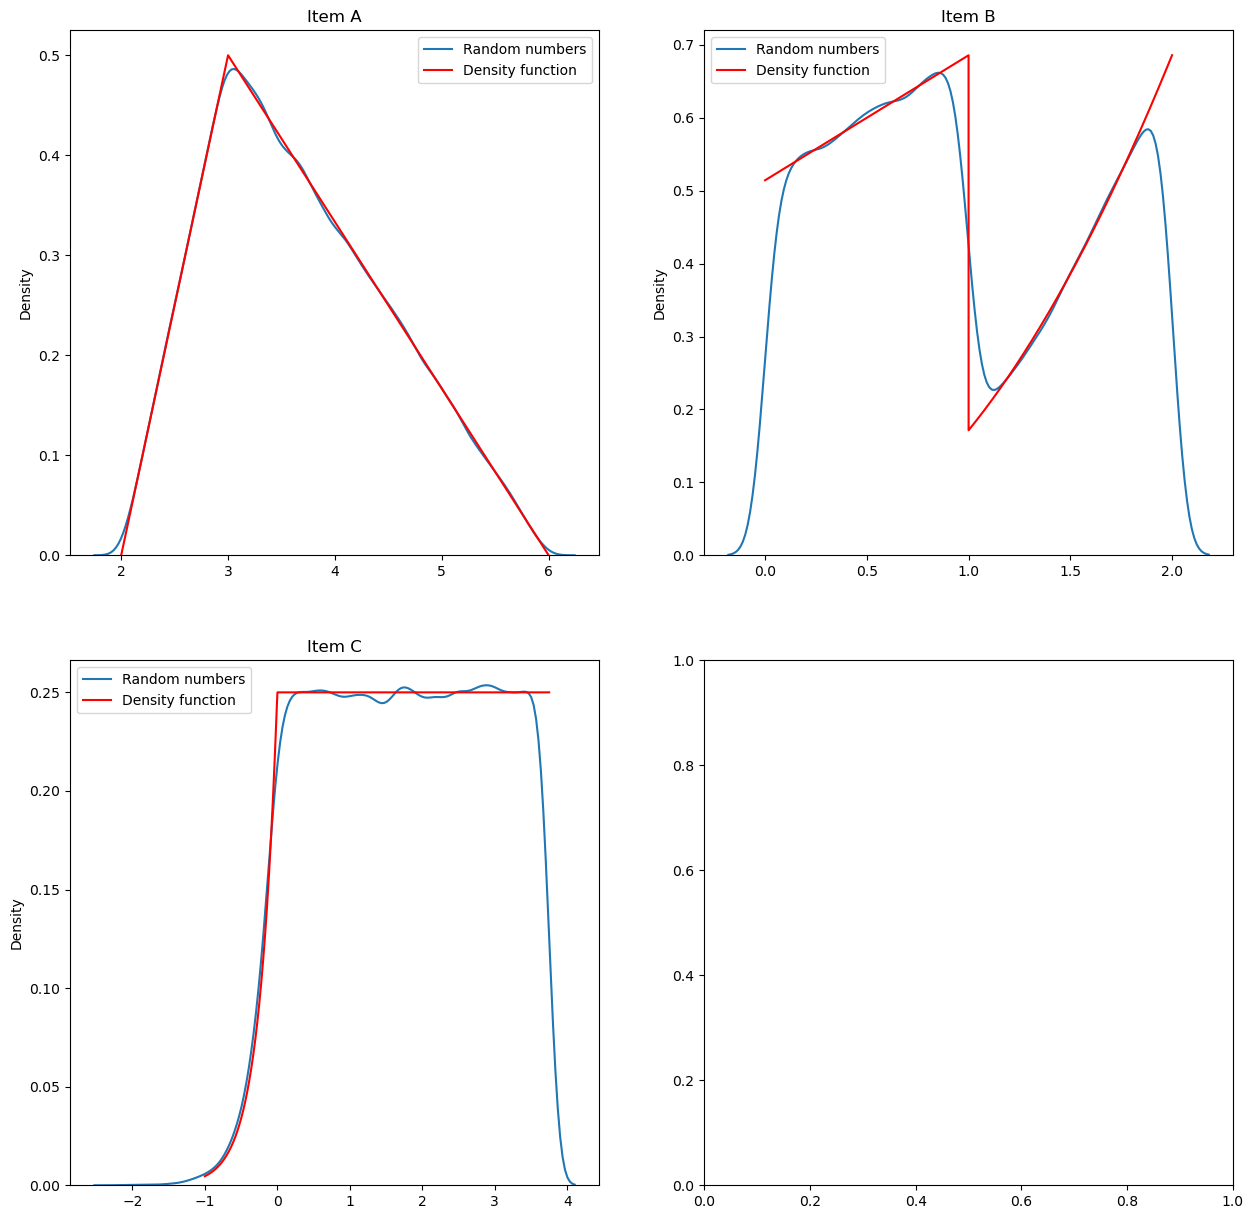

In [11]:
# Item A
def ej1_fa_density(x):
    if 2 <= x <= 3:
        return (x - 2) / 2
    elif 3 <= x <= 6:
        return (2 - x/3) / 2
    return 0

def ej1_fa_inverse(p):
    assert 0 <= p <= 1, "p must be in [0, 1]"
    if 0 <= p <= 1/4:
        return 2 * (1 + np.sqrt(p))
    elif 1/4 <= p <= 1:
        return 6 * (1 - np.sqrt((1 - p) / 3))
    
# Item B
def ej1_fb_density(x):
    if 0 <= x <= 1:
        return 6 * (x + 3) / 35
    elif 1 <= x <= 2:
        return 6 * x**2 / 35
    return 0

def ej1_fb_inverse(p):
    assert 0 <= p <= 1, "p must be in [0, 1]"
    if 0 <= p <= 3/5:
        return -3 + np.sqrt(9 + 35 * p / 3)
    elif 3/5 <= p <= 1:
        return np.cbrt((35 * p - 19) / 2)

# Item C
def ej1_fc_density(x):
    if x <= 0:
        return np.exp(4 * x) / 4
    elif 0 <= x <= 15/4:
        return 1/4
    return 0

def ej1_fc_inverse(p):
    assert 0 < p <= 1, "p must be in (0, 1]"
    if 0 < p <= 1/16:
        return np.log(16 * p) / 4
    elif 1/16 <= p <= 1:
        return (16 * p - 1) / 4

# Generate all variables
sz = 10**5
random_numbers_a = [inverse_transform_method(ej1_fa_inverse) for _ in range(sz)]
random_numbers_b = [inverse_transform_method(ej1_fb_inverse) for _ in range(sz)]
random_numbers_c = [inverse_transform_method(ej1_fc_inverse) for _ in range(sz)]

# Check if the generated random numbers are from the given distributions.
# Graphic representation of the generated random numbers vs the corresponding density function (one above the other).
# Use kdeplot to estimate the density function of the generated random numbers.

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Item A
sns.kdeplot(random_numbers_a, ax=axs[0, 0])
x = np.linspace(2, 6, 10000)
y = [ej1_fa_density(i) for i in x]
axs[0, 0].plot(x, y, color='red')
axs[0, 0].set_title("Item A")
axs[0, 0].legend(["Random numbers", "Density function"])

# Item B
sns.kdeplot(random_numbers_b, ax=axs[0, 1])
x = np.linspace(0, 2, 10000)
y = [ej1_fb_density(i) for i in x]
axs[0, 1].plot(x, y, color='red')
axs[0, 1].set_title("Item B")
axs[0, 1].legend(["Random numbers", "Density function"])

# Item C
sns.kdeplot(random_numbers_c, ax=axs[1, 0])
x = np.linspace(-1, 15/4, 10000)
y = [ej1_fc_density(i) for i in x]
axs[1, 0].plot(x, y, color='red')
axs[1, 0].set_title("Item C")
axs[1, 0].legend(["Random numbers", "Density function"])

plt.show()

## Ejercicio 2

In [12]:
# Pareto
def ej2_pareto_inverse(p, a):
    assert 0 < p < 1 and 0 < a, "Invalid values for p and a"
    return (1 / (1 - p)) ** (1 / a)

def ej2_pareto(a):
    sz = 10**5
    random_numbers = [ej2_pareto_inverse(rnd.random(), a) for _ in range(sz)]

    expected_value = a / (a - 1)
    print(f"Pareto({a})")
    print(f"    Expected mean: {expected_value}")
    print(f"    Actual mean: {np.mean(random_numbers)}")

# Erlang
def ej2_erlang(k, m):
    sz = 10**5
    random_numbers = gamma_distribution(k, m, sz)

    expected_value = k * m
    print(f"Erlang({k}, {m})")
    print(f"    Expected mean: {expected_value}")
    print(f"    Actual mean: {np.mean(random_numbers)}")

# Weibull
def ej2_weibull_inverse(p, l, b):
    assert 0 < p < 1 and 0 < l and 0 < b, "Invalid values for p, l and b"
    return l * (-np.log(1 - p)) ** (1 / b)

def ej2_weibull(l, b):
    sz = 10**5
    random_numbers = [ej2_weibull_inverse(rnd.random(), l, b) for _ in range(sz)]

    expected_value = l / b * math.gamma(1 / b)
    print(f"Weibull({l}, {b})")
    print(f"    Expected mean: {expected_value}")
    print(f"    Actual mean: {np.mean(random_numbers)}")

# Check if the generated random numbers are from the given distributions.
ej2_pareto(2)
ej2_erlang(2, 2)
ej2_weibull(1, 2)

Pareto(2)
    Expected mean: 2.0
    Actual mean: 2.0129023640718775
Erlang(2, 2)
    Expected mean: 4
    Actual mean: 3.998511086981939
Weibull(1, 2)
    Expected mean: 0.8862269254527579
    Actual mean: 0.8845603666541298


## Ejercicio 3

In [13]:
f1 = lambda: exponential_distribution(1/3)[0]
f2 = lambda: exponential_distribution(1/5)[0]
f3 = lambda: exponential_distribution(1/7)[0]
f = [f1, f2, f3]; p = [0.5, 0.3, 0.2]
sz = 10**5
random_numbers = composition_method(p, f, sz)
print(f"Expected mean: {3 * 0.5 + 5 * 0.3 + 7 * 0.2}")
print(f"Actual mean: {np.mean(random_numbers)}")

Expected mean: 4.4
Actual mean: 4.394706548842697


## Ejercicio 4

In [14]:
def ej4_generate():
    y = exponential_distribution(1)[0]
    u = rnd.random()
    return u ** (1 / y)

sz = 10**5
random_numbers = [ej4_generate() for _ in range(sz)]
print(f"Actual mean: {np.mean(random_numbers)}")

Actual mean: 0.40563770508297625


## Ejercicio 5

In [15]:
def ej5_generate(l_list):
    x = [exponential_distribution(l)[0] for l in l_list]
    return max(x), min(x)

sz = 10
l_list = [1, 2, 3]
random_numbers = [ej5_generate(l_list) for _ in range(sz)]
M, m = [x[0] for x in random_numbers], [x[1] for x in random_numbers]
print(f"The samples are:")
print(f"    M: {M}")
print(f"    m: {m}")

sz = 10**5
random_numbers = [ej5_generate(l_list) for _ in range(sz)]
M, m = [x[0] for x in random_numbers], [x[1] for x in random_numbers]
print(f"The means of bigger samples (10^5) are:")
print(f"    M: {np.mean(M)}")
print(f"    m: {np.mean(m)}")

The samples are:
    M: [1.6439806748561103, 0.5401096760906309, 1.0446137365762231, 0.693392573604811, 2.4424754834585003, 0.7248650860728155, 0.2353157473188414, 0.5222086731157571, 1.2023650066637885, 1.4031648958091136]
    m: [0.43056068534964126, 0.025901726172558814, 0.1638433273972819, 0.07672814715029312, 0.05973482352553972, 0.02881937638990219, 0.03250986115226296, 0.276273505195122, 0.075996462074117, 0.31452794769771175]
The means of bigger samples (10^5) are:
    M: 1.215545810425765
    m: 0.16614322023441316


## Ejercicio 6

In [16]:
def ej6_rejection_method(n, sz):
    Y = lambda: rnd.random()
    p = lambda x: n * x ** (n - 1)
    q = lambda y: 1
    c = n

    return rejection_method(Y, p, q, c, sz)

def ej6_inverse_transform_method(n, sz):
    def generate(n):
        u = rnd.random()
        return u ** (1 / n)
    
    return [generate(n) for _ in range(sz)]

def ej6_uniform_max_method(n, sz):
    def generate(n):
        u = [rnd.random() for _ in range(n)]
        return max(u)
    
    return [generate(n) for _ in range(sz)]

# Compare the three methods for n = 2, 3, 50, 100 and sz = 10^4.
n_list = [2, 3, 50, 100]
sz = 10**4

for n in n_list:
    print(f"n = {n}")
    print(f"    Rejection Method:")
    act_time = time()
    random_numbers = ej6_rejection_method(n, sz)
    act_time = time() - act_time
    print(f"        Actual mean: {np.mean(random_numbers)}")
    print(f"        Time: {act_time}")

    print(f"    Inverse Transform Method:")
    act_time = time()
    random_numbers = ej6_inverse_transform_method(n, sz)
    act_time = time() - act_time
    print(f"        Actual mean: {np.mean(random_numbers)}")
    print(f"        Time: {act_time}")

    print(f"    Uniform Max Method:")
    act_time = time()
    random_numbers = ej6_uniform_max_method(n, sz)
    act_time = time() - act_time
    print(f"        Actual mean: {np.mean(random_numbers)}")
    print(f"        Time: {act_time}")

n = 2
    Rejection Method:
        Actual mean: 0.6684458435587926
        Time: 0.013999223709106445
    Inverse Transform Method:
        Actual mean: 0.6635064004181985
        Time: 0.0019998550415039062
    Uniform Max Method:
        Actual mean: 0.6630702928927884
        Time: 0.006000518798828125
n = 3
    Rejection Method:
        Actual mean: 0.7508218737297632
        Time: 0.012001276016235352
    Inverse Transform Method:
        Actual mean: 0.7490253789040352
        Time: 0.0029985904693603516
    Uniform Max Method:
        Actual mean: 0.7499812516052251
        Time: 0.006000041961669922
n = 50
    Rejection Method:
        Actual mean: 0.9801922691429842
        Time: 0.17799997329711914
    Inverse Transform Method:
        Actual mean: 0.98099255748876
        Time: 0.002000570297241211
    Uniform Max Method:
        Actual mean: 0.9806621775206235
        Time: 0.03599977493286133
n = 100
    Rejection Method:
        Actual mean: 0.9901741741821175
        Ti

## Ejercicio 7

In [17]:
def ej7_inverse_transform_method(sz):
    f_inv = lambda p: np.exp(p)
    return [inverse_transform_method(f_inv) for _ in range(sz)]

def ej7_rejection_method(sz):
    Y = lambda: rnd.random() * (np.e - 1) + 1
    p = lambda x: 1 / x
    q = lambda x: 1 / np.e
    c = np.e

    return rejection_method(Y, p, q, c, sz)

def ej7_itemB():
    # Compare the two methods for sz = 10^4.
    sz = 10**5

    print(f"ITEM B")
    print("Inverse Transform Method:")
    act_time = time()
    random_numbers = ej7_inverse_transform_method(sz)
    act_time = time() - act_time
    print(f"    Actual mean: {np.mean(random_numbers)}")
    print(f"    Time: {act_time}")

    print("Rejection Method:")
    act_time = time()
    random_numbers = ej7_rejection_method(sz)
    act_time = time() - act_time
    print(f"    Actual mean: {np.mean(random_numbers)}")
    print(f"    Time: {act_time}")

def ej7_itemC():
    # Calculate P(X <= 2) with the two methods.
    sz = 10**5

    print(f"ITEM C -> The real P(X <= 2) is {np.log(2)}")
    print("Inverse Transform Method:")
    random_numbers = ej7_inverse_transform_method(sz)
    p = len([x for x in random_numbers if x <= 2]) / sz
    print(f"    P(X <= 2): {p}")

    print("Rejection Method:")
    random_numbers = ej7_rejection_method(sz)
    p = len([x for x in random_numbers if x <= 2]) / sz
    print(f"    P(X <= 2): {p}")

ej7_itemB()
ej7_itemC()

ITEM B
Inverse Transform Method:
    Actual mean: 1.7164774570894914
    Time: 0.10299992561340332
Rejection Method:
    Actual mean: 1.716142140314704
    Time: 0.08800005912780762
ITEM C -> The real P(X <= 2) is 0.6931471805599453
Inverse Transform Method:
    P(X <= 2): 0.69465
Rejection Method:
    P(X <= 2): 0.69192


## Ejercicio 8

In [18]:
def ej8_uniform_sum_method(sz):
    def generate():
        u = [rnd.random() for _ in range(2)]
        return sum(u)
    
    return [generate() for _ in range(sz)]

def ej8_inverse_transform_method(sz):
    def f_inv(p):
        assert 0 <= p <= 1, "p must be in [0, 1]"
        if 0 <= p <= 1/2:
            return np.sqrt(2 * p)
        elif 1/2 <= p <= 1:
            return 2 - np.sqrt(2 * (1 - p))
    
    return [inverse_transform_method(f_inv) for _ in range(sz)]

def ej8_rejection_method(sz):
    Y = lambda: rnd.random() * 2
    p = lambda x: x if 0 <= x <= 1 else (2 - x if 1 <= x <= 2 else 0)
    q = lambda x: 1 / 2
    c = 2

    return rejection_method(Y, p, q, c, sz)

def ej8_x0_prob(vals, p_lim):
    p = 1; i = 0; sz = len(vals)
    for x in sorted(vals):
        if p < p_lim: return vals[i - 1]
        sz -= 1; p = sz / len(vals); i += 1
    return vals[-1]

def ej8_mean_comparison():
    sz = 10**5

    print(f"MEAN COMPARISON")
    print("Uniform Sum Method:")
    random_numbers = ej8_uniform_sum_method(sz)
    print(f"    Actual mean: {np.mean(random_numbers)}")

    print("Inverse Transform Method:")
    random_numbers = ej8_inverse_transform_method(sz)
    print(f"    Actual mean: {np.mean(random_numbers)}")

    print("Rejection Method:")
    random_numbers = ej8_rejection_method(sz)
    print(f"    Actual mean: {np.mean(random_numbers)}")
    print()

def ej8_x0_prob_comparison():
    print(f"PROBABILITY COMPARISON of P(X > x_0) = 0.125")
    sz = 10**3; sz2 = 10**3
    print("Uniform Sum Method:")
    x0 = [ej8_x0_prob(ej8_uniform_sum_method(sz), 0.125) for _ in range(sz2)]
    print(f"    x0: {np.mean(x0)}")

    print("Inverse Transform Method:")
    x0 = [ej8_x0_prob(ej8_inverse_transform_method(sz), 0.125) for _ in range(sz2)]
    print(f"    x0: {np.mean(x0)}")

    print("Rejection Method:")
    x0 = [ej8_x0_prob(ej8_rejection_method(sz), 0.125) for _ in range(sz2)]
    print(f"    x0: {np.mean(x0)}")

ej8_mean_comparison()
ej8_x0_prob_comparison()

MEAN COMPARISON
Uniform Sum Method:
    Actual mean: 0.9984801824569683
Inverse Transform Method:
    Actual mean: 0.9984915181817383
Rejection Method:
    Actual mean: 1.0005057856666606

PROBABILITY COMPARISON of P(X > x_0) = 0.125
Uniform Sum Method:
    x0: 1.0008907664987985
Inverse Transform Method:
    x0: 1.0010092666798307
Rejection Method:
    x0: 0.9944406922218311


## Ejercicio 9

In [19]:
# Compare the three methods for sz = 10^5.
sz = 10**5
m = 100; s = 3
print(f"Using Rejection method:")
act_time = time()
random_numbers = normal_distribution(m, s, sz, "rejection")
act_time = time() - act_time
print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
print(f"    Time: {act_time}")

print(f"Using Polar method:")
act_time = time()
random_numbers = normal_distribution(m, s, sz, "polar")
act_time = time() - act_time
print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
print(f"    Time: {act_time}")

print(f"Using Uniform Ratios method:")
act_time = time()
random_numbers = normal_distribution(m, s, sz, "uniform_ratios")
act_time = time() - act_time
print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
print(f"    Time: {act_time}")

Using Rejection method:
    Actual mean: 99.99527288297351 and variance: 8.959684578234418
    Time: 0.38700032234191895
Using Polar method:
    Actual mean: 99.98344367830286 and variance: 8.961572213524386
    Time: 0.23099851608276367
Using Uniform Ratios method:
    Actual mean: 99.98330798657767 and variance: 9.031594698596573
    Time: 0.38899755477905273


## Ejercicio 11

In [20]:
def ej11_cauchy_standardized_distribution(sz):
    def generate():
        while True:
            u, v = rnd.random() * 2 - 1, rnd.random() * 2 - 1
            if v**2 + u**2 <= 1:
                return v / u
    
    return [generate() for _ in range(sz)]


def ej11_cauchy_distribution(l, sz):
    return [l * x for x in ej11_cauchy_standardized_distribution(sz)]

sz = 10**4
l_list = [1, 2.5, 0.3]

for l in l_list:
    act_time = time()
    random_numbers = ej11_cauchy_distribution(l, sz)
    act_time = time() - act_time
    proportion = len([x for x in random_numbers if -l <= x <= l]) / sz
    print(f"Cauchy({l})")
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
    print(f"    Proportion of values in [-l, l]: {proportion} vs. real value: {1/2}")
    print(f"    Time: {act_time}")

Cauchy(1)
    Actual mean: 1.1105181691327615 and variance: 5727.226207198371
    Proportion of values in [-l, l]: 0.5047 vs. real value: 0.5
    Time: 0.007997751235961914
Cauchy(2.5)
    Actual mean: -0.2150487091601447 and variance: 18516.617058004118
    Proportion of values in [-l, l]: 0.5049 vs. real value: 0.5
    Time: 0.013000011444091797
Cauchy(0.3)
    Actual mean: -0.4932563196692502 and variance: 1101.6741493712
    Proportion of values in [-l, l]: 0.5027 vs. real value: 0.5
    Time: 0.006999969482421875


## Ejercicio 12

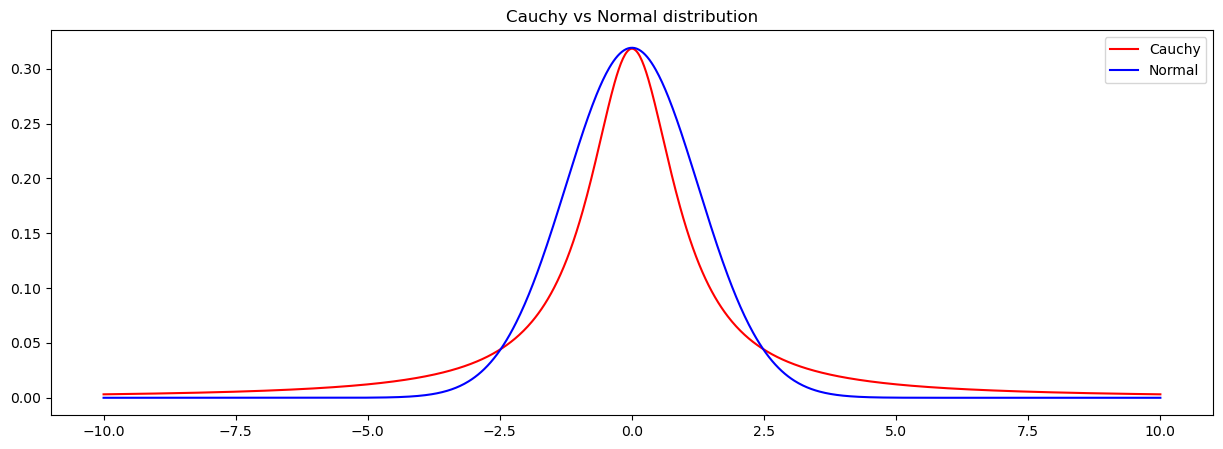

Cauchy(1) with Inverse Transform Method
    Actual mean: 0.12182083097036579 and variance: 1022.9489632617413
    Proportion of values in [-l, l]: 0.4976 vs. real value: 0.5
    Time: 0.010999679565429688
0.9973557010035816
Cauchy(1) with Rejection Method for Normal(0, 1.25) ==> No tiene sentido dada que las cotas (c) no son las correctas nunca
    Actual mean: -0.010854516831312604 and variance: 1.5580482958341424
    Proportion of values in [-l, l]: 0.6247 vs. real value: 0.5
    Time: 0.0879971981048584



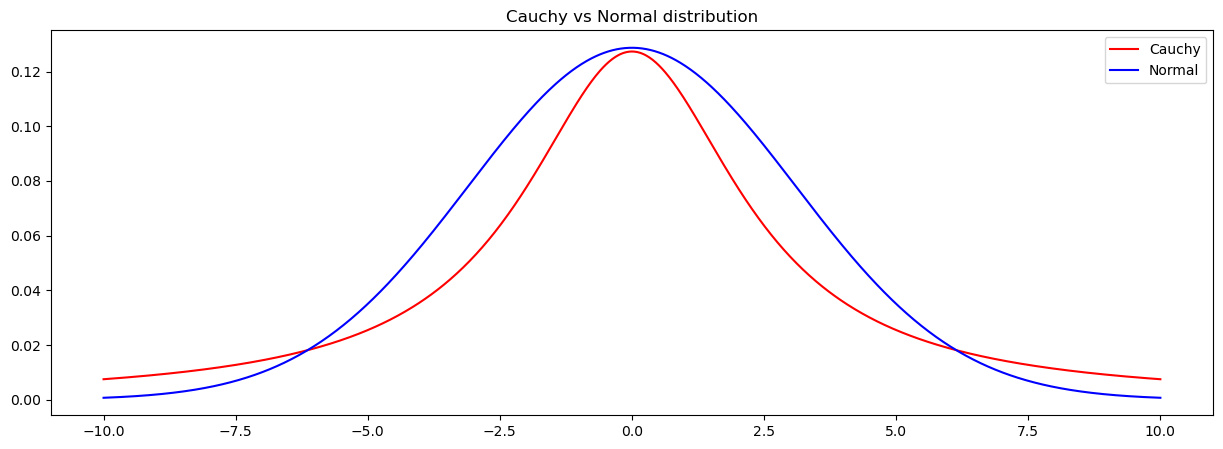

Cauchy(2.5) with Inverse Transform Method
    Actual mean: 0.9667698857732827 and variance: 116512.25107268385
    Proportion of values in [-l, l]: 0.4956 vs. real value: 0.5
    Time: 0.018999814987182617
0.989376855395553
Cauchy(2.5) with Rejection Method for Normal(0, 3.1) ==> No tiene sentido dada que las cotas (c) no son las correctas nunca
    Actual mean: 0.005763436788395348 and variance: 9.44061199312358
    Proportion of values in [-l, l]: 0.6275 vs. real value: 0.5
    Time: 0.08700013160705566



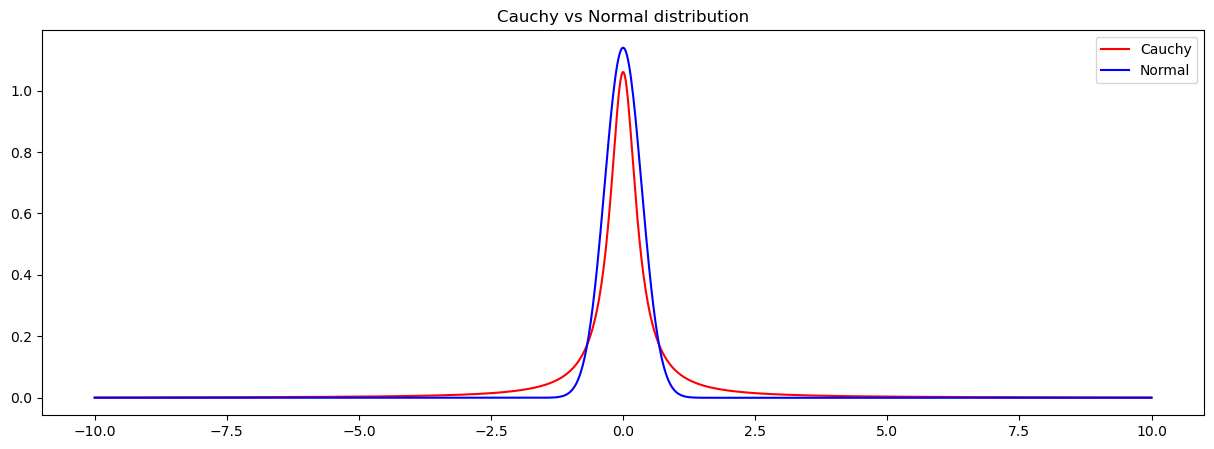

Cauchy(0.3) with Inverse Transform Method
    Actual mean: 0.4473487494199867 and variance: 835.1837221448435
    Proportion of values in [-l, l]: 0.5009 vs. real value: 0.5
    Time: 0.023999691009521484
0.9308653209366761
Cauchy(0.3) with Rejection Method for Normal(0, 0.35) ==> No tiene sentido dada que las cotas (c) no son las correctas nunca
    Actual mean: 0.00031620547915078666 and variance: 0.1228535150158521
    Proportion of values in [-l, l]: 0.6329 vs. real value: 0.5
    Time: 0.17799973487854004



In [21]:
def ej12_cauchy_density(x, l):
    return l/np.pi * 1/(l**2 + x**2)

def ej12_cauchy_cumulative(x, l):
    return 1/2 + np.arctan(x/l) / np.pi

def ej12_cauchy_inverse_cumulative(p):
    assert 0 <= p <= 1, "p must be in [0, 1]"
    return l * np.tan(np.pi * (p - 1/2))

def ej12_cauchy_inverse_transform_method(l):
    return [inverse_transform_method(ej12_cauchy_inverse_cumulative) for _ in range(sz)]

def ej12_cauchy_rejection_method(l, s):
    Y = lambda: normal_distribution(0, s)[0]
    p = lambda x: ej12_cauchy_density(x, l)
    q = lambda x: 1/(s * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*s**2))
    c = p(0)/q(0); print(c)

    return rejection_method(Y, p, q, c, sz)

def ej12_graphical_representation(l, m, s):
    # Graphic a cauchy distribution and a normal one, one above the other.
    x = np.linspace(-10, 10, 1000)
    y = [ej12_cauchy_density(i, l) for i in x]
    y2 = [st.norm.pdf(i, m, s) for i in x]

    plt.figure(figsize=(15, 5))
    plt.plot(x, y, color='red')
    plt.plot(x, y2, color='blue')
    plt.title("Cauchy vs Normal distribution")
    plt.legend(["Cauchy", "Normal"])
    plt.show()

sz = 10**4
l_list = [1, 2.5, 0.3]
s_list = [1.25, 3.1, 0.35]

for i in range(len(l_list)):
    l = l_list[i]; s = s_list[i]
    ej12_graphical_representation(l, 0, s)

    act_time = time()
    random_numbers = ej12_cauchy_inverse_transform_method(l)
    act_time = time() - act_time
    proportion = len([x for x in random_numbers if -l <= x <= l]) / sz
    print(f"Cauchy({l}) with Inverse Transform Method")
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
    print(f"    Proportion of values in [-l, l]: {proportion} vs. real value: {1/2}")
    print(f"    Time: {act_time}")

    act_time = time()
    random_numbers = ej12_cauchy_rejection_method(l, s)
    act_time = time() - act_time
    proportion = len([x for x in random_numbers if -l <= x <= l]) / sz
    print(f"Cauchy({l}) with Rejection Method for Normal(0, {s}) ==> No tiene sentido dada que las cotas (c) no son las correctas nunca")
    print(f"    Actual mean: {np.mean(random_numbers)} and variance: {np.var(random_numbers)}")
    print(f"    Proportion of values in [-l, l]: {proportion} vs. real value: {1/2}")
    print(f"    Time: {act_time}")
    print()

## Ejercicio 14

In [22]:
def ej14_simulate(l, t, tam):
    events = poisson_process_events(l, t)
    r = 0
    for _ in range(len(events)): r += tam[rnd.randint(0, len(tam) - 1)]
    return r

sz = 10**5
l = 5; t = 1; tam = [i for i in range(20, 41)]
random_numbers = [ej14_simulate(l, t, tam) for _ in range(sz)]
print(f"Actual mean: {np.mean(random_numbers)}")

Actual mean: 149.6239


## Ejercicio 15

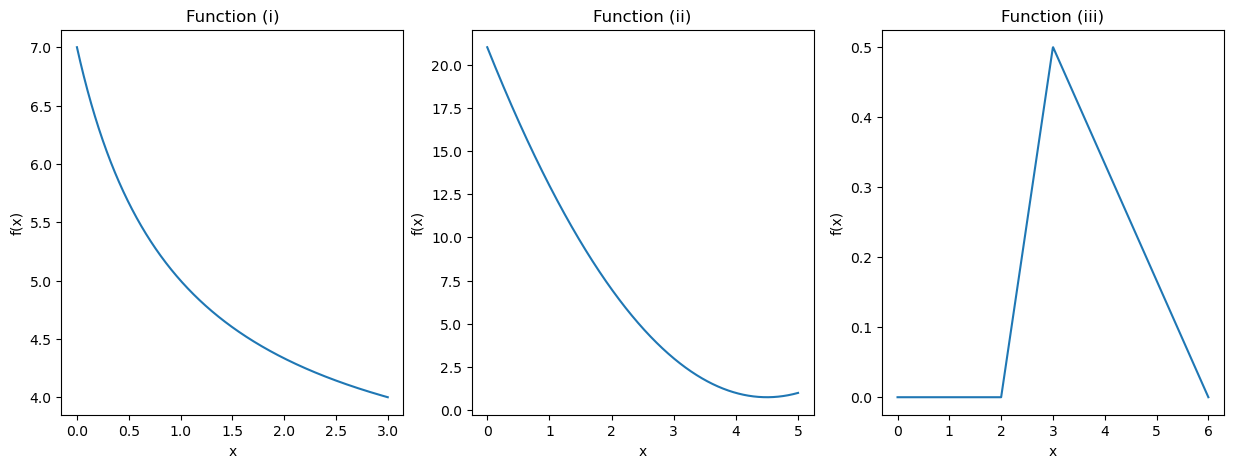

ITEM A: Common method
Function (i): 3 + 4/(x + 1) with x into [0, 3]
    Actual mean: 14.6026
Function (ii): (x - 2) ** 2 - 5 * x + 17 with x into [0, 5]
    Actual mean: 34.0979
Function (iii): x/2-1 if 2 <= x <= 3 else 1-x/6 with x into [2, 6]
    Actual mean: 0.6717

ITEM B: Optimized method
Function (i): 3 + 4/(x + 1) with x into [0, 3] and with intervals [0, 1/2, 1, 2, 3]
    Actual mean: 14.5523
Function (ii): (x - 2) ** 2 - 5 * x + 17 with x into [0, 5] and with intervals [0, 1, 2, 3, 5]
    Actual mean: 34.1678
Function (iii): x/2-1 if 2 <= x <= 3 else 1-x/6 with x into [2, 6] and with intervals [2+1/3, 2+2/3, 3, 3+1/3, 3+2/3, 4, 4+1/3, 4+2/3, 5, 5+1/3, 5+2/3, 6]
    Actual mean: 1.0013



In [23]:
def f1(x): 
    if 0 <= x <= 3: return 3 + 4/(x + 1)
    return 0

def f2(x):
    if 0 <= x <= 5: return (x - 2) ** 2 - 5 * x + 17
    return 0

def f3(x):
    if 2 <= x <= 3: return x/2 - 1
    elif 3 < x <= 6: return 1 - x/6
    return 0

def ej15_graphic_representation():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    x = np.linspace(0, 3, 1000)
    y = [f1(i) for i in x]
    axs[0].plot(x, y)
    axs[0].set_title("Function (i)")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("f(x)")

    x = np.linspace(0, 5, 1000)
    y = [f2(i) for i in x]
    axs[1].plot(x, y)
    axs[1].set_title("Function (ii)")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("f(x)")

    x = np.linspace(0, 6, 1000)
    y = [f3(i) for i in x]
    axs[2].plot(x, y)
    axs[2].set_title("Function (iii)")
    axs[2].set_xlabel("x")
    axs[2].set_ylabel("f(x)")

    plt.show()

# Item A:
def ej15_itemA():
    sz = 10**4

    print(f"ITEM A: Common method")
    print(f"Function (i): 3 + 4/(x + 1) with x into [0, 3]")
    l = 7; t = 3
    mean = np.mean([len(poisson_no_homogeneous_process_events(f1, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")

    print(f"Function (ii): (x - 2) ** 2 - 5 * x + 17 with x into [0, 5]")
    l = 21; t = 5
    mean = np.mean([len(poisson_no_homogeneous_process_events(f2, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")

    print(f"Function (iii): x/2-1 if 2 <= x <= 3 else 1-x/6 with x into [2, 6]")
    l = 1/2; t = 4
    mean = np.mean([len(poisson_no_homogeneous_process_events(f3, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")
    print()

def ej15_itemB():
    sz = 10**4

    print(f"ITEM B: Optimized method")
    print(f"Function (i): 3 + 4/(x + 1) with x into [0, 3] and with intervals [0, 1/2, 1, 2, 3]")
    t = [1/2, 1, 2, 3]
    l = [f1(0), f1(1/2), f1(1), f1(2)]
    mean = np.mean([len(poisson_no_homogeneous_process_events_optimized(f1, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")

    print(f"Function (ii): (x - 2) ** 2 - 5 * x + 17 with x into [0, 5] and with intervals [0, 1, 2, 3, 5]")
    t = [1, 2, 3, 5]
    l = [f2(0), f2(1), f2(2), f2(3)]
    mean = np.mean([len(poisson_no_homogeneous_process_events_optimized(f2, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")

    print(f"Function (iii): x/2-1 if 2 <= x <= 3 else 1-x/6 with x into [2, 6] and with intervals [2+1/3, 2+2/3, 3, 3+1/3, 3+2/3, 4, 4+1/3, 4+2/3, 5, 5+1/3, 5+2/3, 6]")
    t = [2+1/3, 2+2/3, 3, 3+1/3, 3+2/3, 4, 4+1/3, 4+2/3, 5, 5+1/3, 5+2/3, 6]
    l = [f3(2+1/3), f3(2+2/3), f3(3), f3(3), f3(3+1/3), f3(3+2/3), f3(4), f3(4+1/3), f3(4+2/3), f3(5), f3(5+1/3), f3(5+2/3)]
    mean = np.mean([len(poisson_no_homogeneous_process_events_optimized(f3, l, t)) for _ in range(sz)])
    print(f"    Actual mean: {mean}")
    print()

ej15_graphic_representation()
ej15_itemA()
ej15_itemB()
